In [10]:
import sys
sys.path.append('../edaf')

In [11]:
from plot_helpers import *
from decomp import *
from sortedcontainers import SortedList, SortedDict
from loguru import logger
import os, sys, gzip, json
import sqlite3
import pandas as pd
from edaf.core.uplink.preprocess import preprocess_ul
from edaf.core.uplink.analyze_packet import ULPacketAnalyzer
from edaf.core.uplink.analyze_channel import ULChannelAnalyzer
from edaf.core.uplink.analyze_scheduling import ULSchedulingAnalyzer
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import JSON

from pathlib import Path
import ijson

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Remove default handler
logger.remove()
# Add a new handler with level WARNING
logger.add(sys.stdout, level="ERROR")

17

In [19]:
MEAS_DIR = '../meas-oai5g/'
MEAS_LABEL = 's24'
DB_FILE = MEAS_DIR+MEAS_LABEL+'/'+'res_db.sql'
PLOTS_DIR = './plots/'+MEAS_LABEL+'/'

In [20]:
# packet analyzer
analyzer = ULPacketAnalyzer(DB_FILE)
uids_arr = range(analyzer.first_ueipid, analyzer.last_ueipid+1)
packets = analyzer.figure_packettx_from_ueipids(uids_arr)

# sched analyzer
sched_analyzer = ULSchedulingAnalyzer(
    total_prbs_num = 106, 
    symbols_per_slot = 14, 
    slots_per_frame = 20, 
    slots_duration_ms = 0.5, 
    scheduling_map_num_integers = 4,
    max_num_frames=100,
    db_addr = DB_FILE
)

begin_ts = sched_analyzer.first_ts
end_ts = sched_analyzer.last_ts
sched_arr = sched_analyzer.find_resource_schedules_from_ts(begin_ts, end_ts)
sched_sorted_dict = SortedDict({sched['decision_ts']: sched for sched in sched_arr})
bsrupd_arr = sched_analyzer.find_bsr_upd_from_ts(begin_ts, end_ts)
sr_tx_arr = sched_analyzer.find_sr_tx_from_ts(begin_ts, end_ts)
bsr_tx_arr = sched_analyzer.find_bsr_tx_from_ts(begin_ts, end_ts)
sr_bsr_tx_sorted_list = SortedList([sr_tx['timestamp'] for sr_tx in sr_tx_arr]+[bsr_tx['timestamp'] for bsr_tx in bsr_tx_arr])

chan_analyzer = ULChannelAnalyzer(DB_FILE)
begin_ts = chan_analyzer.first_ts
end_ts = chan_analyzer.last_ts
WINDOW_LEN_SECONDS = 2
mcs_arr = chan_analyzer.find_mcs_from_ts(begin_ts,begin_ts+WINDOW_LEN_SECONDS)
tb_arr = chan_analyzer.find_mac_attempts_from_ts(begin_ts,begin_ts+WINDOW_LEN_SECONDS)

2024-10-21 14:16:54.046 | ERROR    | edaf.core.uplink.analyze_channel:find_mac_attempts_from_ts:163 - No harq attempts found


In [22]:
send_ts = analyzer.nlmt_df['timestamps.client.send.wall'].to_numpy()
send_ts = (send_ts)/1e6
receive_ts = analyzer.nlmt_df['timestamps.server.receive.wall'].to_numpy()
receive_ts = (receive_ts)/1e6
idt = (send_ts[1:-1]-send_ts[0:-2])
e2e_delays = receive_ts-send_ts
frame_alignment_delays = np.array(list({packet['id']: get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
scheduling_delays = np.array(list({packet['id']: get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
ran_delays = np.array(list({packet['id']: get_ran_delay(packet) for packet in packets if get_ran_delay(packet)!=None}.values()))
ran_delays_wo_frame_alignment_delay = np.array(list({packet['id']: get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
ran_delays_wo_scheduling_delay = np.array(list({packet['id']: get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) for packet in packets if get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5)!=None}.values()))
queueing_delays = np.array(list({packet['id']: get_queueing_delay(packet) for packet in packets if get_queueing_delay(packet)!=None}.values()))
retx_delays = np.array(list({packet['id']: get_retx_delay(packet) for packet in packets if get_retx_delay(packet)!=None}.values()))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


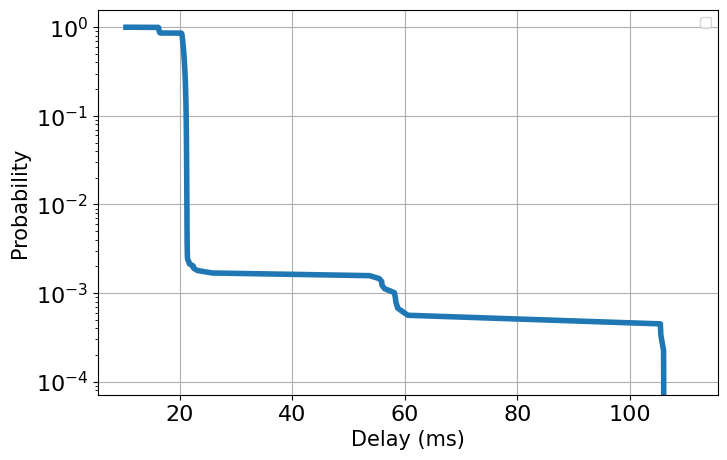

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


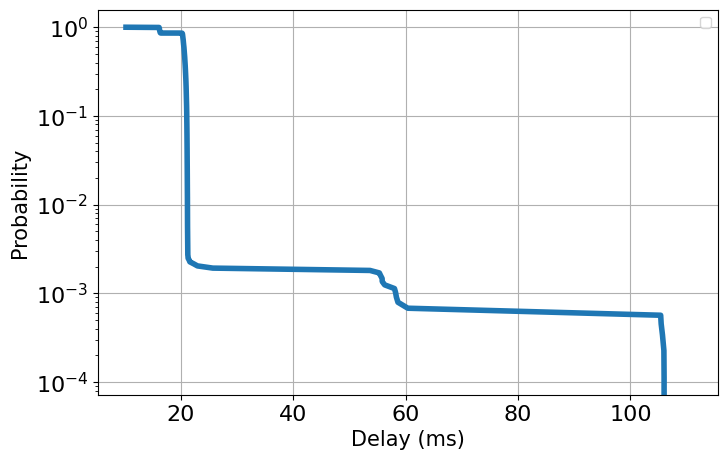

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


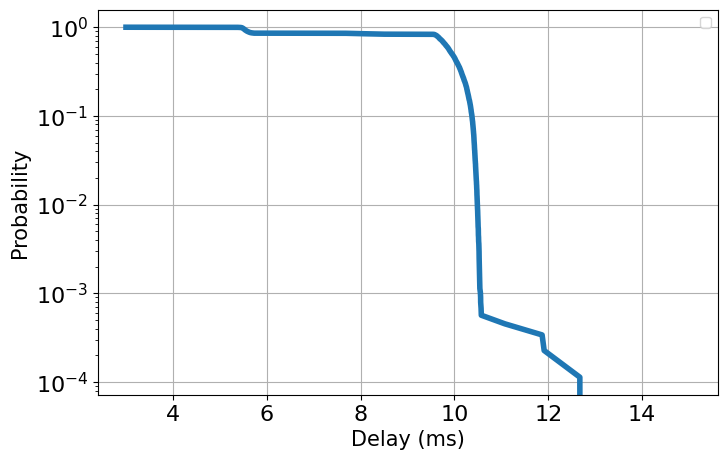

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


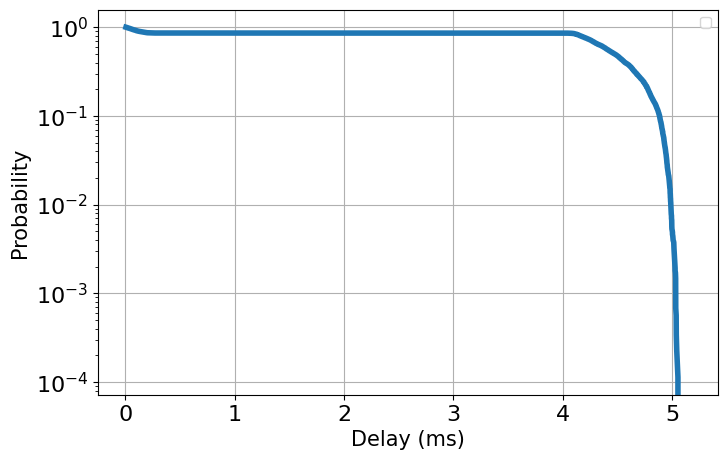

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


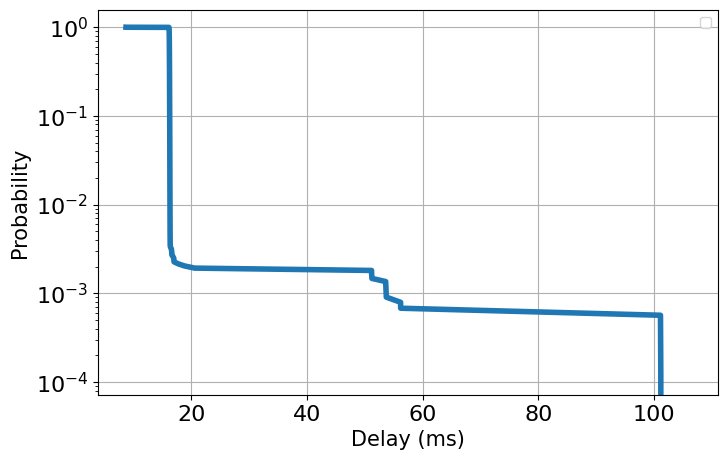

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


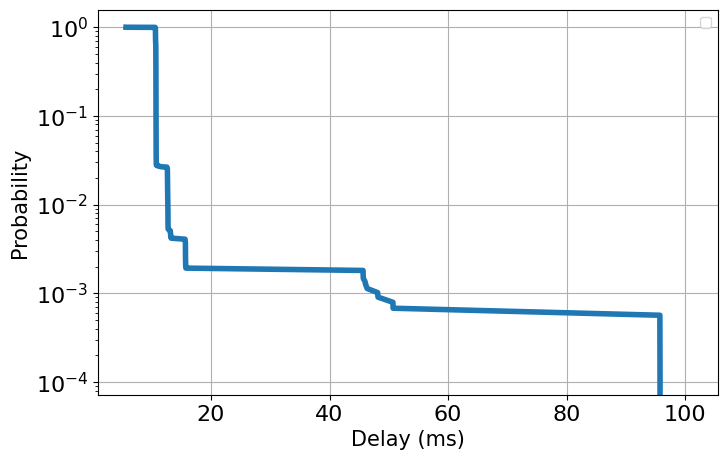

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


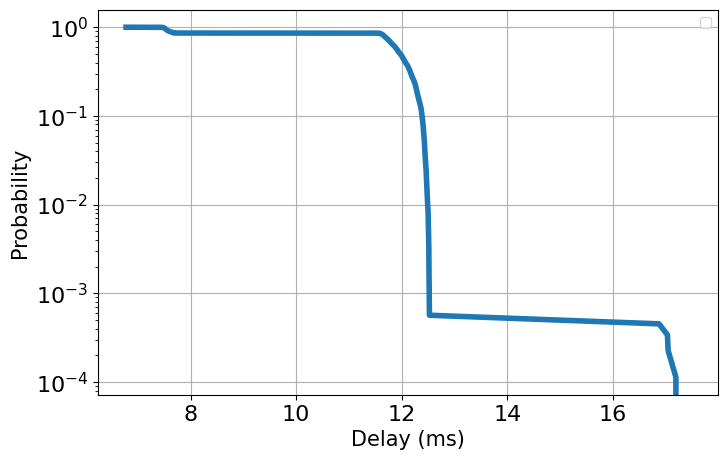

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


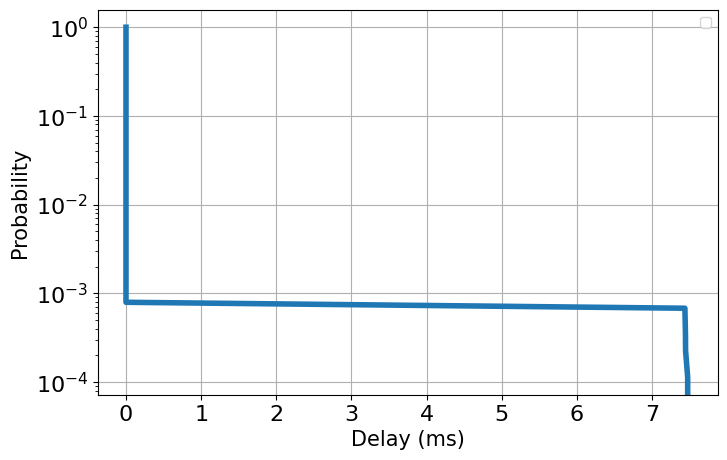

In [16]:
# skip first and last packets
SKIP_FIRST = 1000
SKIP_LAST = 100

fig, ax  = plot_ccdf(e2e_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}e2e_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(ran_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}ran_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(scheduling_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}scheduling_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(frame_alignment_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}frame_alignment_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(ran_delays_wo_frame_alignment_delay[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}ran_delays_wo_frame_alignment_delay_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(ran_delays_wo_scheduling_delay[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}ran_delays_wo_frame_alignment_delay_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(queueing_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}queueing_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

fig, ax  = plot_ccdf(retx_delays[SKIP_FIRST:-SKIP_LAST], '_', figsize=(8, 5))
plt.savefig(f"{PLOTS_DIR}retx_delays_ccdf_plot.png", dpi=300, bbox_inches='tight')  # You can change the file format (e.g., .pdf)
plt.show()

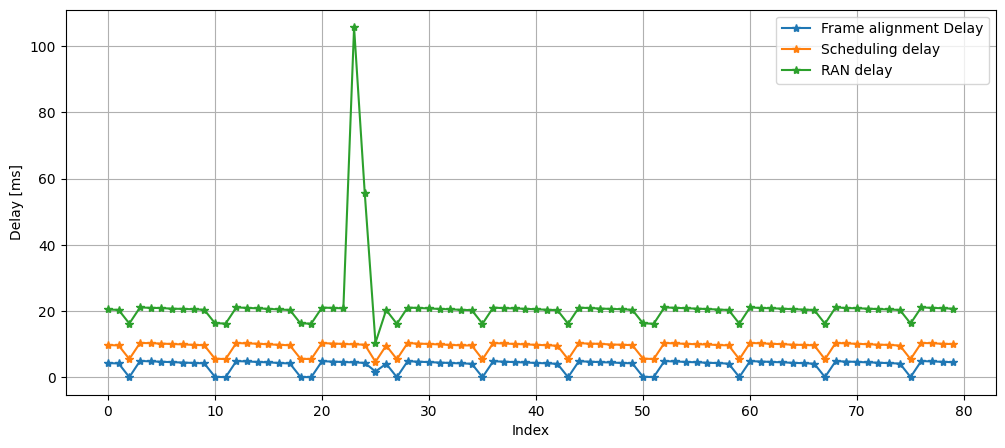

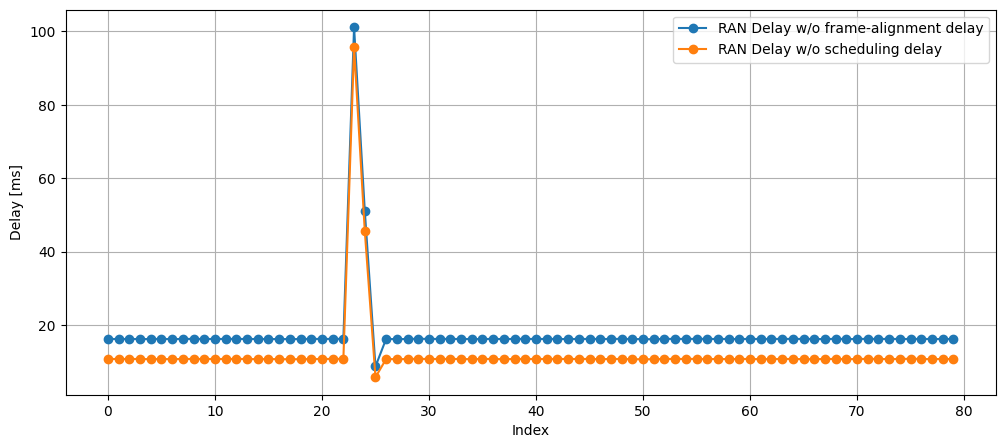

In [17]:
# plotting for frame alignment delay and scheduling delay
index_range = slice(1000, 1080)
SKIP_FIRST = 1000
SKIP_LAST = 100

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12,5))

# Plotting each data set with different markers
ax.plot(frame_alignment_delays[index_range], marker='*', label='Frame alignment Delay')
ax.plot(scheduling_delays[index_range], marker='*', label='Scheduling delay')
ax.plot(ran_delays[index_range], marker='*', label='RAN delay')

# Adding labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Delay [ms]')

# Adding grid
ax.grid(True)

# Adding legend
ax.legend()

# Save the plot
plt.savefig(f"{PLOTS_DIR}ran_delay_timeseries.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## ran delay without frame alignment delay and scheduling
# Create a figure and axes
fig, ax = plt.subplots(figsize=(12,5))

# Plotting each data set with different markers
ax.plot(ran_delays[index_range]-frame_alignment_delays[index_range], marker='o', label='RAN Delay w/o frame-alignment delay')
ax.plot(ran_delays[index_range]-scheduling_delays[index_range], marker='o', label='RAN Delay w/o scheduling delay')

# Adding labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Delay [ms]')

# Adding grid
ax.grid(True)

# Adding legend
ax.legend()

# Save the plot
plt.savefig(f"{PLOTS_DIR}ran_delay_wo_scheduling_timeseries.png", dpi=300, bbox_inches='tight')
